In [2]:

import demeter.utils.torchbox as tb
import demeter.utils.bspline as mbs
# from my_toolbox import update_progress
import demeter.utils.vector_field_to_flow as vff
from demeter.utils.decorators import *
from demeter.utils.constants import *

# Image openning:

H:714, W:714


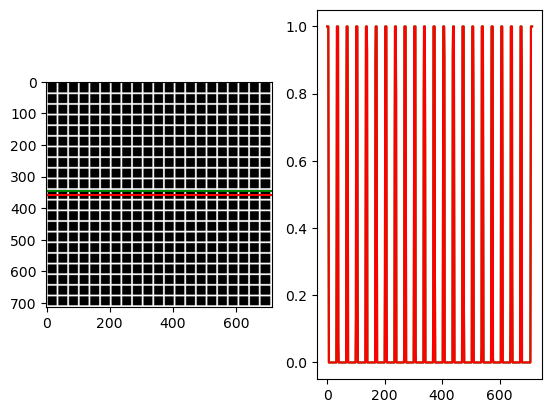

In [3]:
S = tb.reg_open('grid') # ouverture d'une image de grille
sigma = 4
# S = flt.GaussianBlur2d((3*sigma+1,3*sigma+1),(sigma,sigma))(S)  # que l'on floutte
_,_,H,W = S.shape
print(f"H:{H}, W:{W}")
fig, ax = plt.subplots(1,2)
row_cut_id = int(H/2)
ax[0].imshow(S[0,0,:,:],cmap='gray')
ax[0].plot([0,W-1],[row_cut_id-10,row_cut_id-10],'g')
ax[0].plot([0,W-1],[row_cut_id,row_cut_id],'r')
ax[1].plot(S[0,0,row_cut_id-10,:],'g')
ax[1].plot(S[0,0,row_cut_id,:],'r')

# Let's now generate a deformation

/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


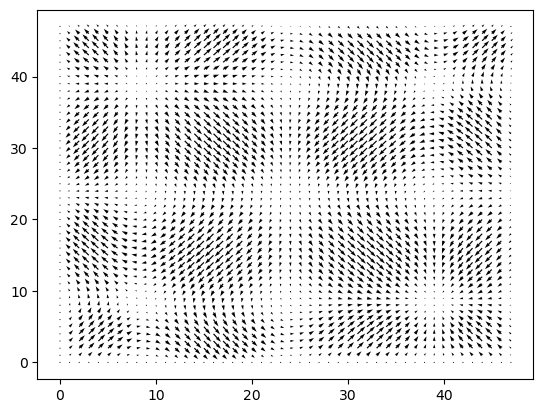

In [4]:
cms = torch.tensor([  # control matrices
    [[0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, +1, 0, -1, 0, -1, 0, -1, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, +1, 0, -1, 0, +1, 0, +1, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, +1, 0, +1, 0, -1, 0, +1, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, -1, 0, -1, 0, -1, 0, +1, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     ],
    [[0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, +1, 0, +1, 0, -1, 0, +1, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],#[0, .2, .75, 1, 0],
     [0, -1, 0, -1, 0, -1, 0, +1, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, +1, 0, -1, 0, -1, 0, -1, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, +1, 0, -1, 0, +1, 0, +1, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0]]
],requires_grad=False,dtype=torch.float)


v = 0.5*mbs.field2D_bspline(cms,(H,W),
                            degree=(3,3),dim_stack=2).unsqueeze(0)

xx, yy = torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W))
fig,ax = plt.subplots()

step =15
ax.quiver(v[0,::step,::step,0],v[0,::step,::step,1])

plt.show()

# Lagrangian formulation:


N =  6 => n_step =  64

Computation of Lagrangian_scheme done in  0:00:00s and 0.147cents  s


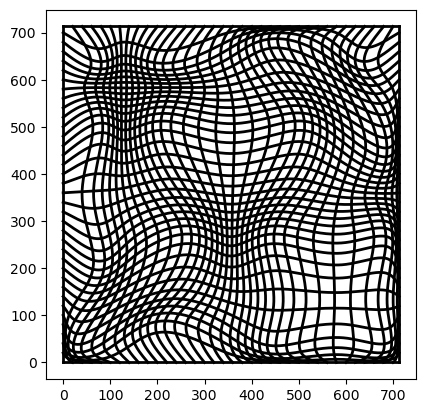

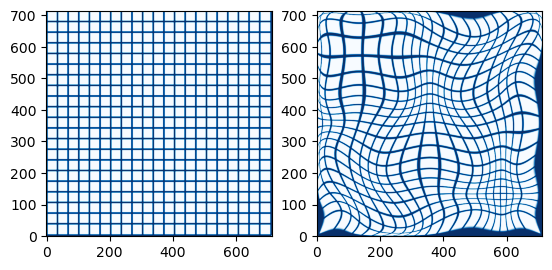

In [5]:
# exp(2^(-N) * v) realisation. Set N = None for an automatique
@time_it
def Lagrangian_scheme(S,v,N = None):

    fast_exp = vff.FieldIntegrator(
        method='fast_exp',
        N=N,
        dx_convention='2square')
    deform_i = fast_exp(v.clone(),forward=False,verbose = True)
    deform_i = tb.square2pixel_convention(deform_i,grid=True)
    # deform_i = tb.make_regular_grid(v.shape) - v
    tb.gridDef_plot_2d(deform_i,step=20)
    T_l = tb.imgDeform(S,deform_i,dx_convention='pixel')

    return T_l,deform_i


N = None
r = 0.7
T_l,deform_l = Lagrangian_scheme(S,r*v)
fig,ax = plt.subplots(1,2)
cmap = 'Blues'
ax[0].imshow(S[0,0,:,:],cmap= cmap,origin='lower')
ax[1].imshow(T_l[0,0,:,:],cmap= cmap,origin='lower')
plt.show()


# Eulerian formulation :

de $ T = S \circ \Phi^{-1}$ on en déduit le schémas  $\dot S = - <\nabla S,v > $

In [6]:
@time_it
def Eulerian_scheme(S,v,n_steps,t_max = 1,device = 'cpu',verbose = True):
    def schemas(image,field):
        """
        compute $- <\nabla S, field >

        :param S:  (0,0,H,W) tensor image
        :param field: (H,W,2) vector field
        :return: a (H,W) tensor that could be assimilated to an image
        """
        grad_I = tb.spacialGradient(image,dx_convention='2square')
        grad_I_scalar_v = (grad_I[0]*tb.grid2im(field)).sum(dim=1)
        return  -grad_I_scalar_v * dt

    dt = t_max/n_steps   # time step
    field = v.to(device)
    T_e = S.detach().clone().to(device)
    for t in torch.linspace(0,t_max,n_steps):
        tmp = schemas(T_e,field)
        T_e += tmp #* dt
    # if verbose:
    #     print('time elapsed for ',n_steps,' iterations : ',format_time(end - start),' s.')
    return T_e

vmax =  tensor(0.2222) h 0.0028011204481792717 n_step =  225937
tensor(9.8354e-07)

Computation of Eulerian_scheme done in  0:21:25s and 0.773cents  s


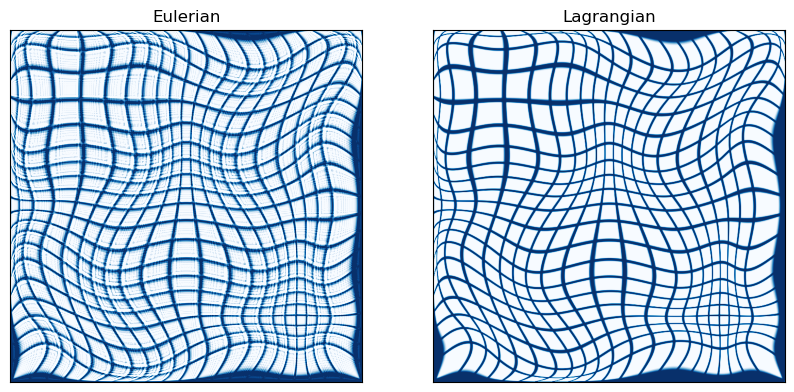

In [8]:
# CFL condition
n_step = int( 2*v.abs().max()*(H-1)*(W-1)) + 1
# a faster but
# n_step = 500
print('vmax = ',v.abs().max(),'h',2/max(v.shape),'n_step = ',n_step)
print(v.abs().max()/n_step)
T_e = Eulerian_scheme(S,v,n_steps= n_step,t_max=r,device = 'cpu')


fig,ax = plt.subplots(1,2,figsize = (10,5))
set_ticks_off(ax)
ax[0].imshow(T_e[0,0,:,:].cpu().detach().numpy(),cmap= cmap,origin='lower',
             vmin=0,vmax=1)
ax[0].set_title('Eulerian')
ax[1].imshow(T_l[0,0,:,:].detach().numpy(),cmap= cmap,origin='lower',
             vmin=0,vmax=1)
ax[1].set_title('Lagrangian')

# fig.colorbar(gloup[0,0,:,:].detach().numpy()
             # ,ax=ax[1])
plt.show()

# Comparison of Eulerian vs Lagrangian

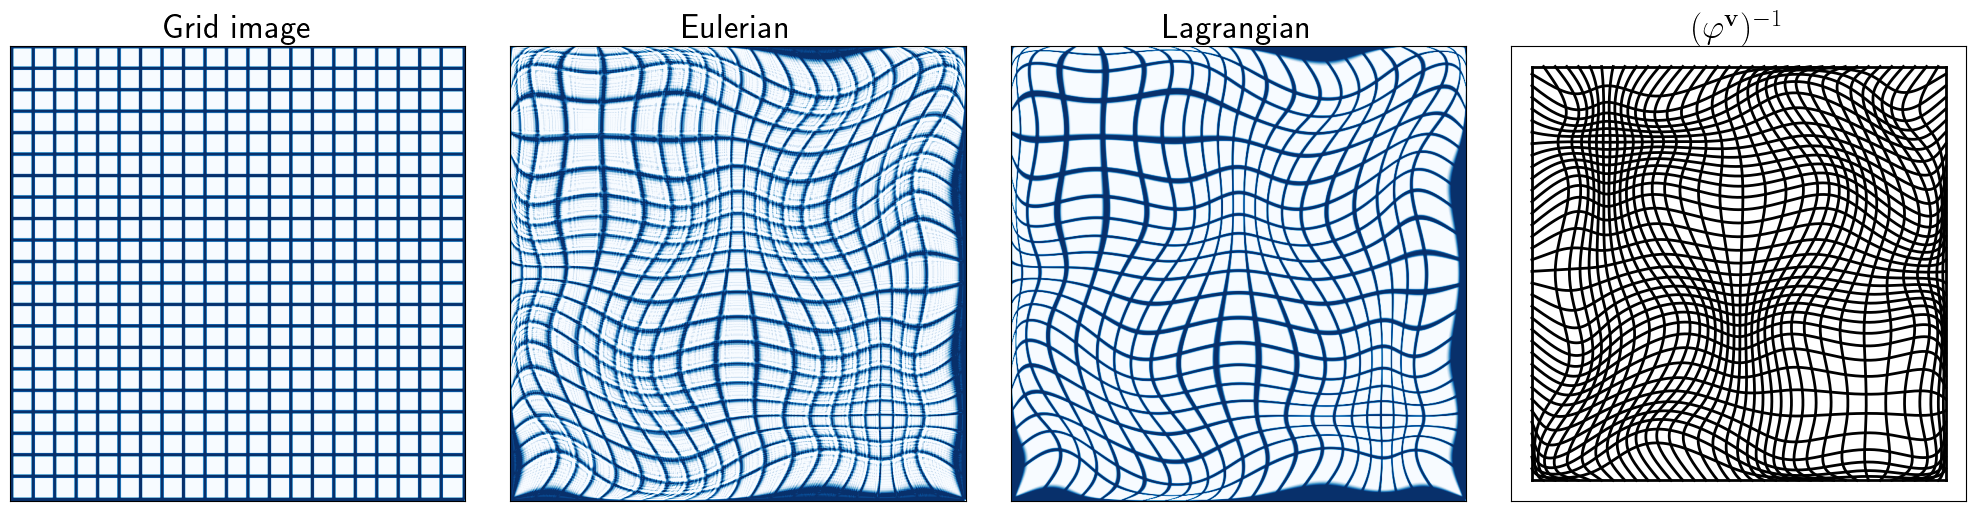

In [9]:
cmap = 'Blues'
plt.rcParams['text.usetex'] = True
fig,ax = plt.subplots(1,4,figsize=(20,5),constrained_layout=True)
set_ticks_off(ax)
ax[0].imshow(S[0,0,:,:],cmap= cmap,origin='lower')
ax[0].set_title('Grid image',fontsize=25)
ax[1].imshow(T_e[0,0,:,:].cpu().detach().numpy(),cmap= cmap,origin='lower',
             vmin=0,vmax=1)
ax[1].set_title('Eulerian',fontsize=25)
ax[2].imshow(T_l[0,0,:,:].detach().numpy(),cmap= cmap,origin='lower',
             vmin=0,vmax=1)
ax[2].set_title('Lagrangian',fontsize=25)

# ax[3].imshow(tb.imCmp(T_e.cpu(),T_l),origin='lower')

tb.gridDef_plot_2d(deform_l,ax=ax[3],step=20)
ax[3].set_title(r'$(\varphi^{\mathbf{v}})^{-1}$',fontsize=25)
path = ""
# fig.savefig(path+'img_EulLag.pdf',dpi= 100)